<a href="https://colab.research.google.com/github/JR-1991/Catalax/blob/master/examples/NeuralODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import catalax
except ImportError:
    !pip install git+https://github.com/JR-1991/Catalax.git

In [2]:
import json

import jax.numpy as jnp
import catalax as ctx
import catalax.neural as ctn

In [10]:
# Initialize the model
model = ctx.Model(name="Simple menten model")

# Add species
model.add_species("s1")

# Add ODEs
model.add_ode("s1", "- (v_max * s1) / ( K_m + s1)")

# Prepare the model for bayes and define priors 
model.parameters.v_max.value = 7.0
model.parameters.K_m.value = 100.0

model

In [4]:
# Load data
time = jnp.load("./data/time.npy")
data = jnp.load("./data/data.npy")
y0s = jnp.load("./data/y0s.npy")
initial_conditions = json.load(open("./data/initial_conditions.json", "r"))

print(f"Time: {time.shape} | Data: {data.shape} | Initial Conditions: {y0s.shape}")

Time: (120, 6) | Data: (120, 6, 1) | Initial Conditions: (120, 1)


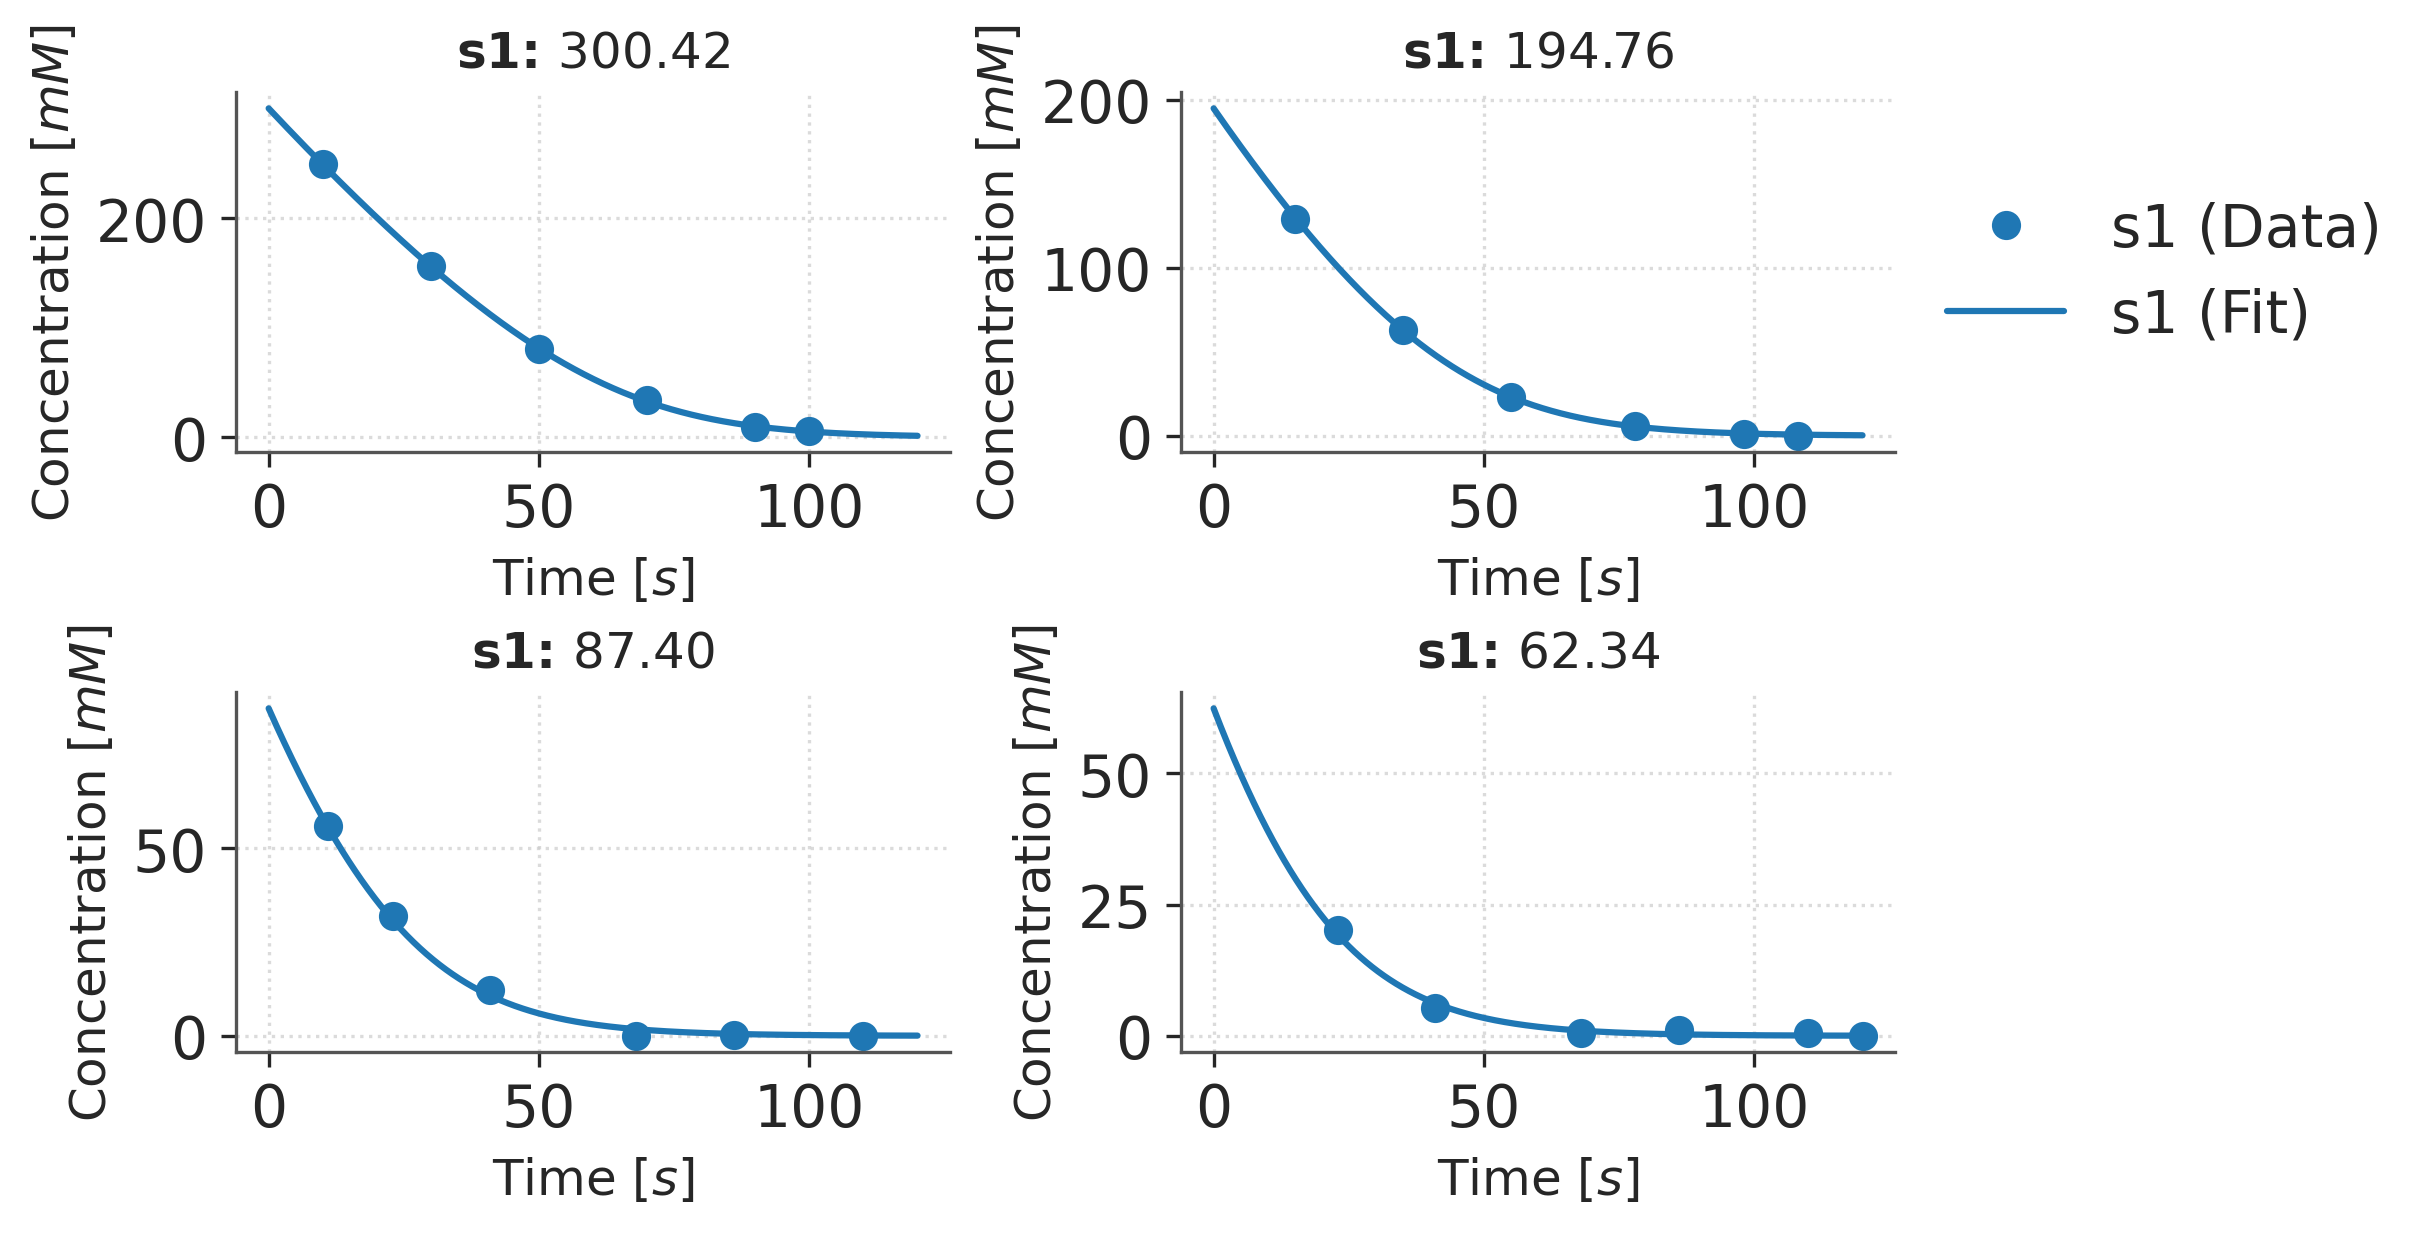

In [5]:
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
)

In [6]:
# Create a neural ODE model
rbf = ctn.RBFLayer(0.6)
neural_ode = ctn.NeuralODE.from_model(model, width_size=16, depth=1, activation=rbf)

# Set up a training strategy (You can interchange the loss function too!)
strategy = ctn.Strategy()
strategy.add_step(lr=1e-3, length=0.1, steps=1000, batch_size=20, alpha=0.1)
strategy.add_step(lr=1e-3, steps=3000, batch_size=20, alpha=0.01)
strategy.add_step(lr=1e-4, steps=5000, batch_size=20, alpha=0.01)

# Train neural ODE
trained = ctn.train_neural_ode(
    model=neural_ode,
    data=data,
    times=time,
    inital_conditions=y0s,
    strategy=strategy,
    sigma=0.03,
    n_augmentations=10,
    print_every=10,
    weight_scale=1e-3,
    save_milestones=False, # Set to True to save model checkpoints
    # log="progress.log", # Uncomment this line to log progress
)



🚀 Training NeuralODE...

🔸 Step #1
├── lr: 0.001
├── batch size: 20
├── length: 10.0%
├── l2 reg: 0.1
├── train: mlp
│


╰── loss: 11.3757 mae: 3.9339: : 1010it [00:13, 72.85it/s]                          




🔸 Step #2
├── lr: 0.001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 5.0348 mae: 2.5387: : 3010it [00:32, 92.41it/s]                           




🔸 Step #3
├── lr: 0.0001
├── batch size: 20
├── length: 100.0%
├── l2 reg: 0.01
├── train: mlp
│


╰── loss: 0.7372 mae: 0.9638: : 5010it [00:45, 111.14it/s]                         

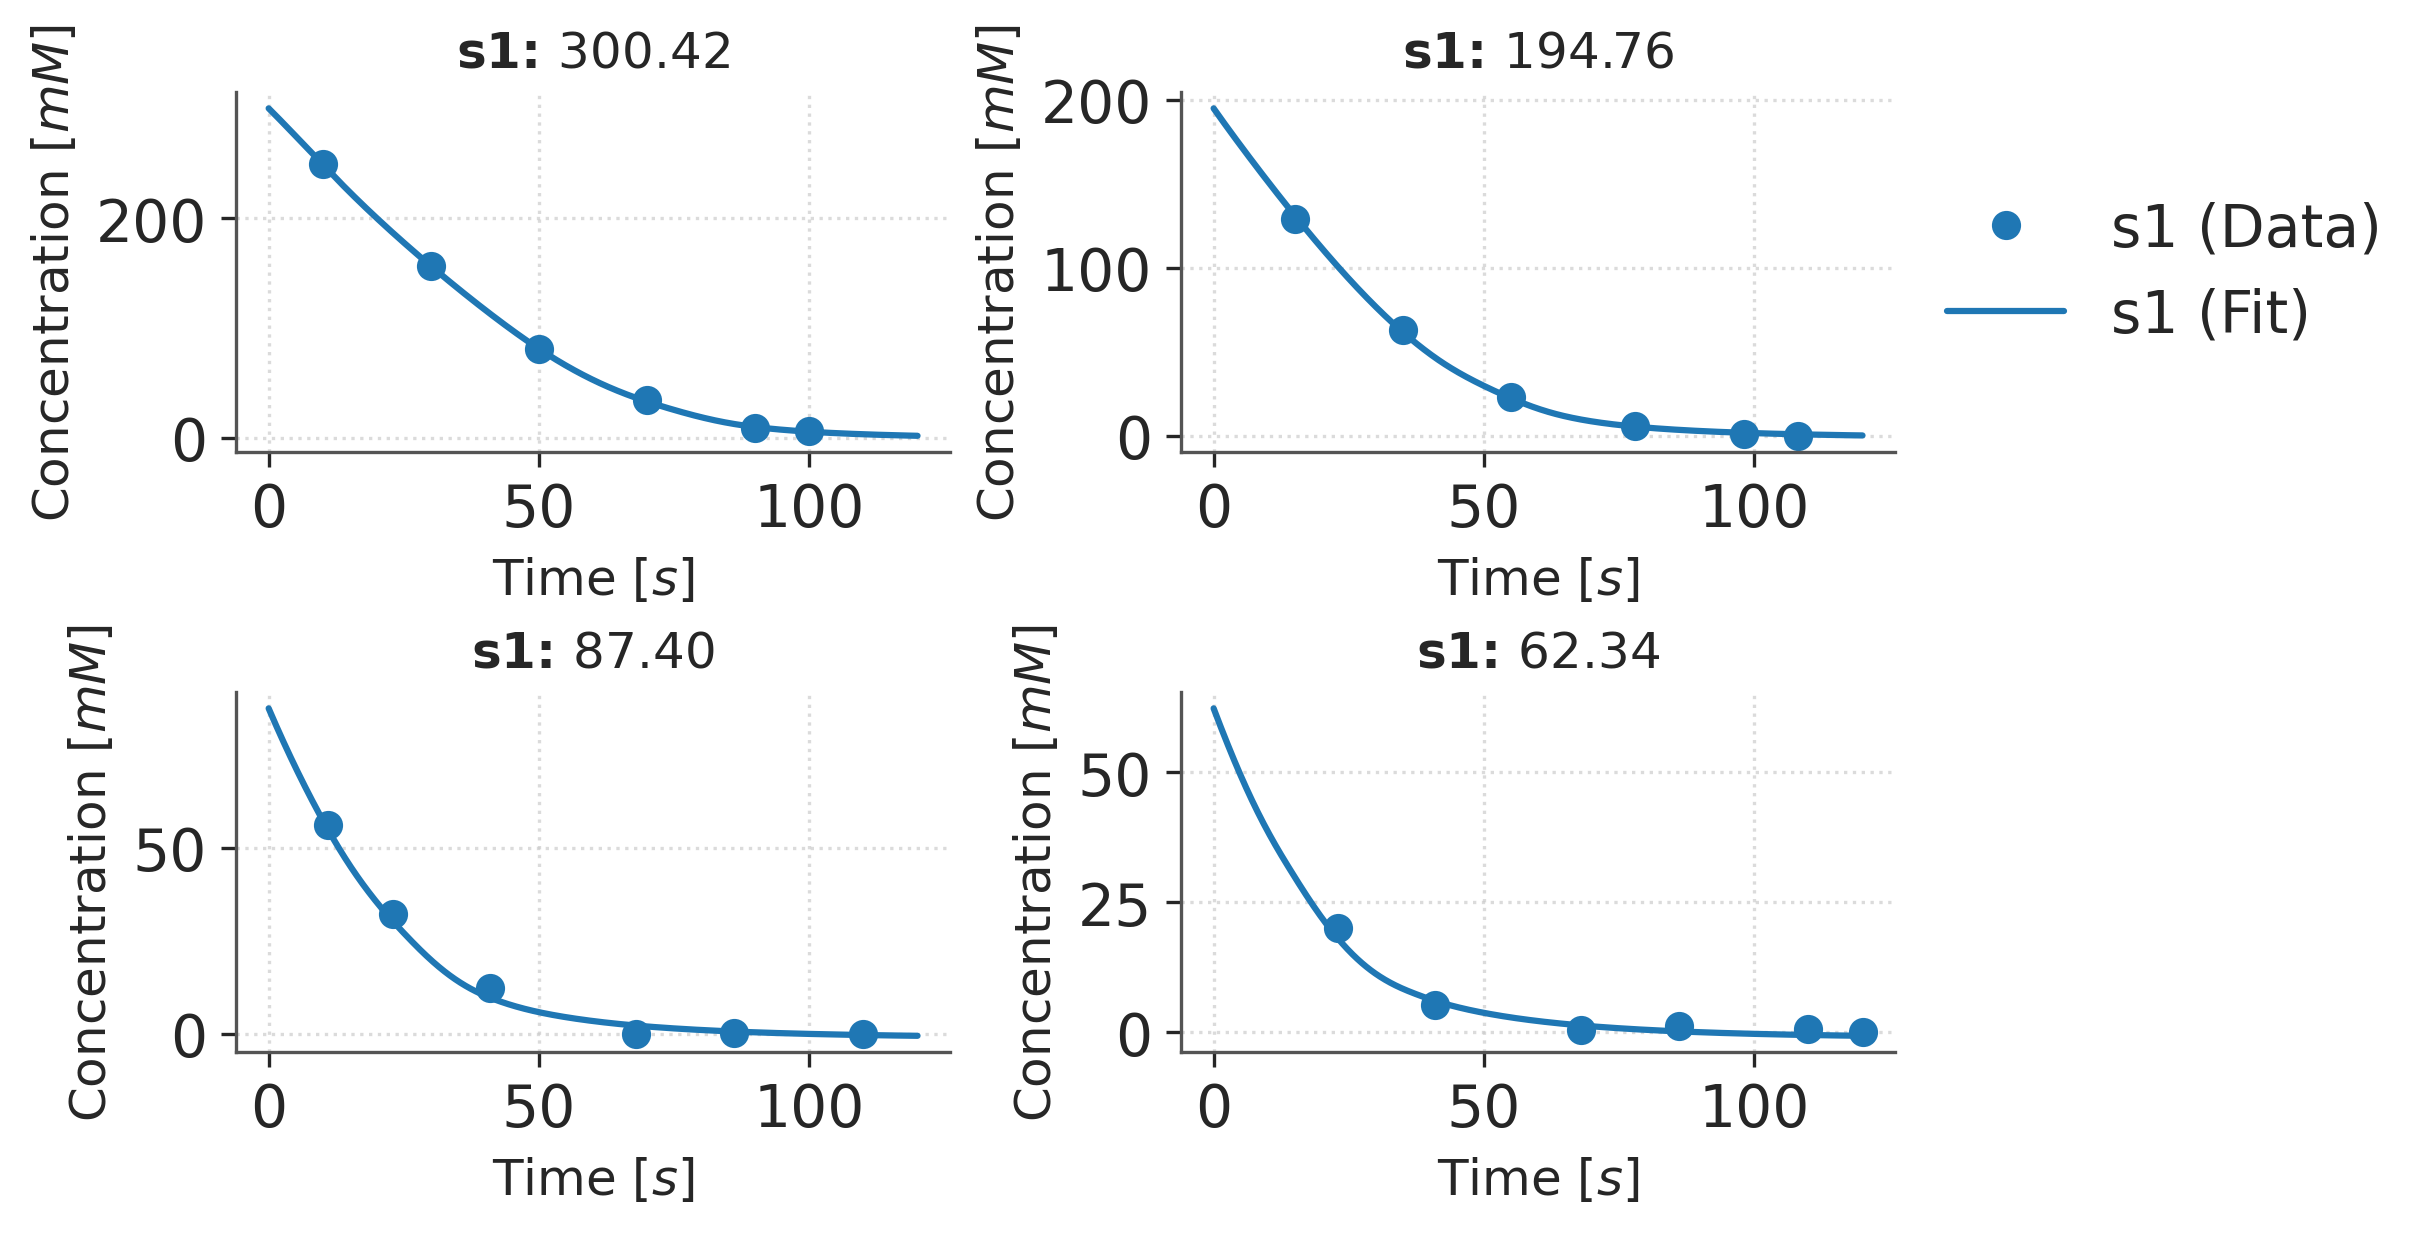

In [8]:
# Save model and visualize fit
trained.save_to_eqx("./trained/", "menten_trained")
f = ctx.visualize(
    model=model,
    data=data[:4],
    times=time[:4],
    neural_ode=trained,
    initial_conditions=initial_conditions[:4],
    figsize=(4,2),
)